# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [12]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

device = torch.device("mps")


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in /Users/kimhongil/.cache/torch/hub/huggingface_pytorch-transformers_main


## Self-Attention (주석 추가)

In [13]:
from torch import nn
from math import sqrt

# 셀프 어텐션
class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim # 입력 차원  (보통 어휘 크기((vocab_size)))
    self.d_model = d_model     # 임베딩 차원 (모델 크기에 따라 다르다. BERT는 768..)

    self.wq = nn.Linear(input_dim, d_model)  # 쿼리(입력 -> d_model 차원 변환)
    self.wk = nn.Linear(input_dim, d_model)  #   키(입력 -> d_model 차원 변환)
    self.wv = nn.Linear(input_dim, d_model)  #   값(입력 -> d_model 차원 변환)

    # 최종 출력을 위한 선형 레이어 (d_model -> d_model)
    self.dense = nn.Linear(d_model, d_model)

    # 소프트맥스 (어텐션 가중치 계산을 위해((마지막 차원 기준으로 소프트맥스 수행)))
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    ### 1. Q, K, V 벡터 생성 – 입력을 통해 Wq, Wk, Wv를 선형 변환하여 Q, K, V를 만듬
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
	# Q (Query): 현재 기준이 되는 토큰 (검색 기준)
    # K (Key): 모든 토큰 (기준과 비교할 대상)
    # V (Value): 최종적으로 가중치를 적용해 반환할 값
    # 어텐션 매커니즘은 Q와 K의 유사도를 계산하여 V에서 어떤 정보를 얼마만큼 가져올지 결정한다.



    ### 2. 어텐션 스코어 계산 – 쿼리(Q)와 키(K)를 내적하여 유사도 계산 (Q * K^T)
    # W_q와 W_k는 문맥적으로 유사한 단어를 높은 내적 값을 내뱉도록 학습뇌다.
    # B(Batch Size: 배치 크기), S(Sequence length: 시퀀스 길이), D(Embedding Dimension: 임베딩 차원)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    # 어텐션에서 내적 결과를 에너지라고도 한다.
    # - 에너지 값이 크면: 쿼리와 키가 매우 유사하다는 의미
    # - 에너지 값이 작을수록 두 벡터간의 상관성이 낮다는 의미

    ### 3. 스코어 정규화 – sqrt(d_model)로 나눠서 스케일링 (값이 너무 크거나 작아지는 문제 방지(vanishing/exploding))
    score = score / sqrt(self.d_model)

    ### 4. 마스킹 – 필요 시 패딩이나 특정 토큰을 제외하기 위해 마스크를 적용
    if mask is not None:
      score = score + (mask * -1e9) # (마스크된 위치(값 1))에 매우 큰 음수 추가 -> 소프트 맥스에서 0이됨)

    ### 5. 소프트맥스를 사용해 어텐션 가중치 계산
    score = self.softmax(score)

	### 6. 어텐션 가중치 적용 – 값 벡터(V)에 어텐션 가중치를 곱해 최종 결과 생성
    # Wv는 유사도가 높은 단어로부터 '올바른 정보'를 가져오도록 학습된다.
    result = torch.matmul(score, v) # 가중치 합이 적용되어 컥텍스트 벡터가 된다.
    # 컨텍스트 벡터는 각 단어(밸류 벡터)에 어텐션 스코어를 곱한 가중합입니다.
    # C_3 = A_<3, 1>V3 + A_<3, 2>V2 + A<3, 3>V3 + A<3, 4>V4


    ### 7. 출력 변환 – 선형 변환(dense)을 통해 최종 출력 생성
    result = self.dense(result)


    return result

## [MY CODE] Multi-Head-Attention (MHA) 구현

In [14]:
# 멀티 헤드 어텐션
class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    self.input_dim = input_dim # 입력 차원  (보통 어휘 크기((vocab_size)))
    self.d_model = d_model     # 임베딩 차원 (모델 크기에 따라 다르다. BERT는 768..)
    self.n_heads = n_heads      # 헤드 수 (멀티 헤드)
    assert d_model % n_heads == 0, "d_model은 n_heads로 나누어 떨어져야 합니다."
    # 헤드는 독립접으로 어텐션을 수행하는 하나의 어텐션 매커니즘이다.

    # 각 헤드의 차원
    self.depth = d_model // n_heads # (D' = d_model / H)

    self.wq = nn.Linear(input_dim, d_model)  # 쿼리(입력 -> d_model 차원 변환)
    self.wk = nn.Linear(input_dim, d_model)  #   키(입력 -> d_model 차원 변환)
    self.wv = nn.Linear(input_dim, d_model)  #   값(입력 -> d_model 차원 변환)

    # 최종 출력을 위한 선형 레이어 (d_model -> d_model)
    self.dense = nn.Linear(d_model, d_model)

    # 소프트맥스 (어텐션 가중치 계산을 위해((마지막 차원 기준으로 소프트맥스 수행)))
    self.softmax = nn.Softmax(dim=-1)

  def split_heads(self, x, batch_size):
    """
    Q, K, V를 헤드 수(n_heads)로 나누고 transpose하여 (B, H, S, D) 형태로 변환
    """
    x = x.view(batch_size, -1, self.n_heads, self.depth)
    return x.transpose(1, 2)  # (B, S, H, D') -> (B, H, S, D')

  def forward(self, x, mask):
    # 🔹 1. Q, K, V 벡터 생성 – 입력을 통해 Wq, Wk, Wv를 선형 변환하여 Q, K, V를 만듬
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    # Q (Query): 현재 기준이 되는 토큰 (검색 기준)
    # K (Key): 모든 토큰 (기준과 비교할 대상)
    # V (Value): 최종적으로 가중치를 적용해 반환할 값
    # 어텐션 매커니즘은 Q와 K의 유사도를 계산하여 V에서 어떤 정보를 얼마만큼 가져올지 결정한다.

    # 🔹 2. 헤드로 나눈다.
    batch_size = x.shape[0]
    q = self.split_heads(q, batch_size)  # (B, H, S, D)
    k = self.split_heads(k, batch_size)  # (B, H, S, D)
    v = self.split_heads(v, batch_size)  # (B, H, S, D)

    # 🔹 3. 어텐션 스코어 계산 – 쿼리(Q)와 키(K)를 내적하여 유사도 계산 (Q * K^T)
    # W_q와 W_k는 문맥적으로 유사한 단어를 높은 내적 값을 내뱉도록 학습뇌다.
    # B(Batch Size: 배치 크기), S(Sequence length: 시퀀스 길이), D(Embedding Dimension: 임베딩 차원)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, H, S, D) * (B, H, D, S) = (B, H, S, S)
    # 어텐션에서 내적 결과를 에너지라고도 한다.
    # - 에너지 값이 크면: 쿼리와 키가 매우 유사하다는 의미
    # - 에너지 값이 작을수록 두 벡터간의 상관성이 낮다는 의미

    # 🔹 4. 스코어 정규화 – sqrt(d_model)로 나눠서 스케일링 (값이 너무 크거나 작아지는 문제 방지(vanishing/exploding))
    # 멀티헤드 어텐션에서는 임베딩 차원이 작아졌으므로 depth로 나너야 함
    score = score / sqrt(self.depth)

    # 🔹 5. 마스킹 – 필요 시 패딩이나 특정 토큰을 제외하기 위해 마스크를 적용
    if mask is not None:
      score = score + (mask * -1e9) # (마스크된 위치(값 1))에 매우 큰 음수 추가 -> 소프트 맥스에서 0이됨)

    # 🔹 6. 소프트맥스를 사용해 어텐션 가중치 계산
    score = self.softmax(score)

    # 🔹 7. 어텐션 가중치 적용 – 값 벡터(V)에 어텐션 가중치를 곱해 최종 결과 생성
    # Wv는 유사도가 높은 단어로부터 '올바른 정보'를 가져오도록 학습된다.
    result = torch.matmul(score, v) # 가중치 합이 적용되어 컥텍스트 벡터가 된다.
    # 컨텍스트 벡터는 각 단어(밸류 벡터)에 어텐션 스코어를 곱한 가중합입니다.
    # C_3 = A_<3, 1>V3 + A_<3, 2>V2 + A<3, 3>V3 + A<3, 4>V4

    """
    입력 임베딩 (B, S, 512)
    └── (512차원을 8개의 헤드로 나눔)
          ├── 1번째 헤드 (64차원)
          ├── 2번째 헤드 (64차원)
          ├── ...
          └── 8번째 헤드 (64차원)
    └── (다시 병합하여 512차원으로 복원)
    """
    # 🔹 8. 헤드 합치기
    # 차원 증가가 아니라, 중복 합치기가 아니라 단순히 더 작게 나누었던 차원을 다시 합치는 과정
    result = result.transpose(1, 2).contiguous()  # (B, S, H, D)
    result = result.view(batch_size, -1, self.d_model)  # (B, S, D)

    # 🔹 9. 출력 변환 – 선형 변환(dense)을 통해 최종 출력 생성
    result = self.dense(result)


    return result

## Positional encoding (주석 추가)

트랜스포머 모델은 순차적인 RNN과 달리 위치 정보가 자연스럽게 반영되지 않는다. 따라서 위치 정보를 추가적으로 부여하는 방식이 필요하다.
- 임베딩 차원의 짝수 인덱스에는 사인(Sin)
- 홀수 인덱스에는 코사인(Cos)을 적용해 단어 위치에 따라 규칙적이고 주기적인 패턴을 적용한다.
장점:
-> -1 ~ 1 사이의 값으로 너무 크지 않다.
-> 서로 다른 주기를 사용함으로써 중복되지 않다. (Sin(1)과 Sin(2)는 매우 다른 값을 가진다.)

$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [15]:
import numpy as np


def get_angles(pos, i, d_model):
    """
    pos: 위치 (Position) → 문장의 각 단어의 위치 (배치의 단어 인덱스)
    i: 임베딩 차원의 인덱스 (0, 1, 2, ...)
    d_model: 전체 임베딩 차원 (예: 256, 512 등)

    각 위치(pos)와 임베딩 차원(i)에 따라 고유한 각도 값(angle_rates)을 계산하는 함수
    이 각도는 위치 정보를 학습하지 않고도 네트워크가 순서를 인식할 수 있게 해줌
    """

    # 주어진 위치와 임베딩 차원에 따라 각도 변화율(angle_rates) 계산
    # 10000은 트랜스포머에서 사용하는 기준 상수로, 주파수 스케일링 역할을 함
    # i가 커질수록(차원이 증가할수록) 각도 변화율이 작아짐
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    """
    position: 문장의 최대 길이 (시퀀스 길이, 예: 400)
    d_model: 임베딩 차원 (예: 256)

    각 위치에 대한 사인(Sin)과 코사인(Cosine)을 기반으로 포지셔널 인코딩 행렬을 생성
    """
    # 각 위치(pos)와 임베딩 차원(i)에 대해 get_angles 함수를 호출해 각도 계산
    # np.arange(position)[:, None]: 위치 인덱스 (세로로 확장) [[0] [1] [2] [3] [4] ...]
    # np.arange(d_model)[None, :]: 임베딩 차원 인덱스 (가로로 확장) [[0 1 2 3 4 ...]]
    # 결과적으로 (position, d_model) 크기의 각도 행렬(angle_rads)을 생성
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    # 짝수 인덱스(0, 2, 4...) → 사인(Sin) 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 홀수 인덱스(1, 3, 5...) → 코사인(Cos) 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # Positional Encoding을 3차원으로 확장 (Batch 차원 추가)
    # (1, position, d_model) 형태 → 배치 차원을 추가해 여러 문장에 적용 가능
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400

## [MY CODE] TransformerLayer - Layer normalization, dropout, residual connection 구현

In [16]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, n_heads, dropout_rate=0.1):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    # 🔹 기존 Self-Attention을 MultiHeadAttention으로 변경
    self.mha = MultiHeadAttention(input_dim, d_model, n_heads)

    # 🔹 Layer Normalization 추가
    self.layer_norm1 = nn.LayerNorm(d_model)
    self.layer_norm2 = nn.LayerNorm(d_model)

    # 🔹 Dropout 추가
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dropout2 = nn.Dropout(dropout_rate)

    # 🔹 Feed Forward Network (FFN)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    # 🔹 Multi-Head Attention + Dropout + Residual Connection + LayerNorm
    x1 = self.mha(x, mask)
    x1 = self.dropout1(x1)
    x1 = self.layer_norm1(x1 + x)

    # 🔹 Feed Forward Network + Dropout + Residual Connection + LayerNorm
    x2 = self.ffn(x1)
    x2 = self.dropout2(x2)
    x2 = self.layer_norm2(x2 + x1)

    return x2

In [17]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    # 🔹 임베딩 층: 단어의 정수 인덱스를 d_model 차원의 벡터로 변환
    self.embedding = nn.Embedding(vocab_size, d_model)

    # 🔹 포지셔널 인코딩: 입력 토큰의 위치 정보를 부여하는 역할
    # 위치에 따라 다른 사인(sin) 및 코사인(cos) 값을 더해 순서를 인식 가능
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)

    # 🔹 트랜스포머 인코더 레이어 리스트 생성
    # n_layers 개수만큼 TransformerLayer를 쌓음
    # 각 레이어는 멀티헤드 어텐션(MHA) + FFN으로 구성
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])

    # 🔹 최종 선형 분류기 (1차원 출력)
    # 문장의 첫 번째 토큰(주로 [CLS] 토큰)에 대한 예측을 수행
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    # 🔹 마스킹 처리
    mask = (x == tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
    #mask = mask[:, None, :]
    # mask shape: (B, 1, 1, S)
    # 어텐션 스코어에서 브로드캐스트되어 (B, H, S, S)로 확장됨
    seq_len = x.shape[1]

    # 🔹 임베딩 및 포지셔널 인코딩 적용
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    # 🔹 트랜스포머 레이어 통과
    for layer in self.layers:
      x = layer(x, mask)

    # 🔹 첫 번째 토큰([CLS])을 분류기로 전달
    x = x[:, 0]
    x = self.classification(x)

    return x

In [18]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [19]:
def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

## [MY CODE] 학습
- 5-layer 4-head
- 저장/로드 추가

In [20]:
from torch.optim import Adam
import time

lr = 0.001
n_layers = 5
n_heads  = 4

model = TextClassifier(len(tokenizer), 32, n_layers, 32, n_heads)
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

n_epochs = 50
start_epoch = 0

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []

checkpoint_path = 'checkpoint_TextClassifier.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=torch.device('mps'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -2:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

Epoch   1 | Time: 66.46 seconds | Loss: 0.52 | Train Acc: 0.821 | Test Acc: 0.794
Epoch   2 | Time: 60.17 seconds | Loss: 0.36 | Train Acc: 0.892 | Test Acc: 0.829
Epoch   3 | Time: 60.31 seconds | Loss: 0.29 | Train Acc: 0.925 | Test Acc: 0.839
Epoch   4 | Time: 60.05 seconds | Loss: 0.22 | Train Acc: 0.954 | Test Acc: 0.837
Epoch   5 | Time: 60.86 seconds | Loss: 0.17 | Train Acc: 0.956 | Test Acc: 0.833
Epoch   6 | Time: 60.13 seconds | Loss: 0.13 | Train Acc: 0.977 | Test Acc: 0.834
Epoch   7 | Time: 60.56 seconds | Loss: 0.10 | Train Acc: 0.985 | Test Acc: 0.830
Epoch   8 | Time: 60.05 seconds | Loss: 0.08 | Train Acc: 0.990 | Test Acc: 0.832
Epoch   9 | Time: 60.53 seconds | Loss: 0.06 | Train Acc: 0.991 | Test Acc: 0.831
Epoch  10 | Time: 60.62 seconds | Loss: 0.06 | Train Acc: 0.991 | Test Acc: 0.827
Epoch  11 | Time: 59.82 seconds | Loss: 0.05 | Train Acc: 0.992 | Test Acc: 0.825
Epoch  12 | Time: 60.80 seconds | Loss: 0.04 | Train Acc: 0.995 | Test Acc: 0.826
Epoch  13 | Time

In [21]:
from torchinfo import summary

# 모델 정보 출력
summary(model, input_size=(64, max_len), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [64, 1]                   12,800
├─Embedding: 1-1                         [64, 400, 32]             976,704
├─ModuleList: 1-2                        --                        --
│    └─TransformerLayer: 2-1             [64, 400, 32]             --
│    │    └─MultiHeadAttention: 3-1      [64, 400, 32]             4,224
│    │    └─Dropout: 3-2                 [64, 400, 32]             --
│    │    └─LayerNorm: 3-3               [64, 400, 32]             64
│    │    └─Sequential: 3-4              [64, 400, 32]             2,112
│    │    └─Dropout: 3-5                 [64, 400, 32]             --
│    │    └─LayerNorm: 3-6               [64, 400, 32]             64
│    └─TransformerLayer: 2-2             [64, 400, 32]             --
│    │    └─MultiHeadAttention: 3-7      [64, 400, 32]             4,224
│    │    └─Dropout: 3-8                 [64, 400, 32]             

In [22]:
model.to(device)  # 다시 MPS로 이동 (중요!)

for epoch in range(start_epoch, n_epochs):
  start_time = time.time()  # 에포크 시작 시간 기록
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device).float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    average_loss = total_loss / len(train_loader)

  with torch.no_grad():
    model.eval()

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    time_list.append(epoch_time)
    average_loss_list.append(average_loss)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")

## [LOG]
```
Epoch   1 | Time: 66.46 seconds | Loss: 0.52 | Train Acc: 0.821 | Test Acc: 0.794
Epoch   2 | Time: 60.17 seconds | Loss: 0.36 | Train Acc: 0.892 | Test Acc: 0.829
Epoch   3 | Time: 60.31 seconds | Loss: 0.29 | Train Acc: 0.925 | Test Acc: 0.839
Epoch   4 | Time: 60.05 seconds | Loss: 0.22 | Train Acc: 0.954 | Test Acc: 0.837
Epoch   5 | Time: 60.86 seconds | Loss: 0.17 | Train Acc: 0.956 | Test Acc: 0.833
Epoch   6 | Time: 60.13 seconds | Loss: 0.13 | Train Acc: 0.977 | Test Acc: 0.834
Epoch   7 | Time: 60.56 seconds | Loss: 0.10 | Train Acc: 0.985 | Test Acc: 0.830
Epoch   8 | Time: 60.05 seconds | Loss: 0.08 | Train Acc: 0.990 | Test Acc: 0.832
Epoch   9 | Time: 60.53 seconds | Loss: 0.06 | Train Acc: 0.991 | Test Acc: 0.831
Epoch  10 | Time: 60.62 seconds | Loss: 0.06 | Train Acc: 0.991 | Test Acc: 0.827
Epoch  11 | Time: 59.82 seconds | Loss: 0.05 | Train Acc: 0.992 | Test Acc: 0.825
Epoch  12 | Time: 60.80 seconds | Loss: 0.04 | Train Acc: 0.995 | Test Acc: 0.826
Epoch  13 | Time: 60.65 seconds | Loss: 0.04 | Train Acc: 0.995 | Test Acc: 0.826
Epoch  14 | Time: 59.90 seconds | Loss: 0.04 | Train Acc: 0.996 | Test Acc: 0.831
Epoch  15 | Time: 60.14 seconds | Loss: 0.03 | Train Acc: 0.995 | Test Acc: 0.828
Epoch  16 | Time: 60.32 seconds | Loss: 0.03 | Train Acc: 0.995 | Test Acc: 0.833
Epoch  17 | Time: 59.76 seconds | Loss: 0.03 | Train Acc: 0.996 | Test Acc: 0.829
Epoch  18 | Time: 60.26 seconds | Loss: 0.03 | Train Acc: 0.997 | Test Acc: 0.828
Epoch  19 | Time: 60.24 seconds | Loss: 0.03 | Train Acc: 0.995 | Test Acc: 0.828
Epoch  20 | Time: 59.94 seconds | Loss: 0.02 | Train Acc: 0.994 | Test Acc: 0.820
Epoch  21 | Time: 60.62 seconds | Loss: 0.03 | Train Acc: 0.995 | Test Acc: 0.820
Epoch  22 | Time: 60.36 seconds | Loss: 0.03 | Train Acc: 0.992 | Test Acc: 0.815
Epoch  23 | Time: 59.99 seconds | Loss: 0.03 | Train Acc: 0.996 | Test Acc: 0.825
Epoch  24 | Time: 60.66 seconds | Loss: 0.02 | Train Acc: 0.996 | Test Acc: 0.829
Epoch  25 | Time: 60.15 seconds | Loss: 0.02 | Train Acc: 0.996 | Test Acc: 0.829
Epoch  26 | Time: 59.89 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.828
Epoch  27 | Time: 60.50 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.828
Epoch  28 | Time: 60.18 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.830
Epoch  29 | Time: 59.73 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.830
Epoch  30 | Time: 60.44 seconds | Loss: 0.02 | Train Acc: 0.996 | Test Acc: 0.831
Epoch  31 | Time: 60.48 seconds | Loss: 0.03 | Train Acc: 0.997 | Test Acc: 0.826
Epoch  32 | Time: 59.84 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.829
Epoch  33 | Time: 60.52 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.832
Epoch  34 | Time: 60.24 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.826
Epoch  35 | Time: 59.60 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.827
Epoch  36 | Time: 59.98 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.832
Epoch  37 | Time: 60.20 seconds | Loss: 0.02 | Train Acc: 0.988 | Test Acc: 0.826
Epoch  38 | Time: 59.82 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.829
Epoch  39 | Time: 60.39 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.828
Epoch  40 | Time: 59.98 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.823
Epoch  41 | Time: 59.80 seconds | Loss: 0.02 | Train Acc: 0.996 | Test Acc: 0.831
Epoch  42 | Time: 60.54 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.826
Epoch  43 | Time: 60.27 seconds | Loss: 0.02 | Train Acc: 0.997 | Test Acc: 0.826
Epoch  44 | Time: 59.48 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.826
Epoch  45 | Time: 60.42 seconds | Loss: 0.01 | Train Acc: 0.998 | Test Acc: 0.829
Epoch  46 | Time: 59.72 seconds | Loss: 0.02 | Train Acc: 0.990 | Test Acc: 0.824
Epoch  47 | Time: 59.99 seconds | Loss: 0.02 | Train Acc: 0.996 | Test Acc: 0.831
Epoch  48 | Time: 60.24 seconds | Loss: 0.02 | Train Acc: 0.998 | Test Acc: 0.830
Epoch  49 | Time: 59.53 seconds | Loss: 0.01 | Train Acc: 0.998 | Test Acc: 0.828
Epoch  50 | Time: 59.79 seconds | Loss: 0.01 | Train Acc: 0.998 | Test Acc: 0.830
```

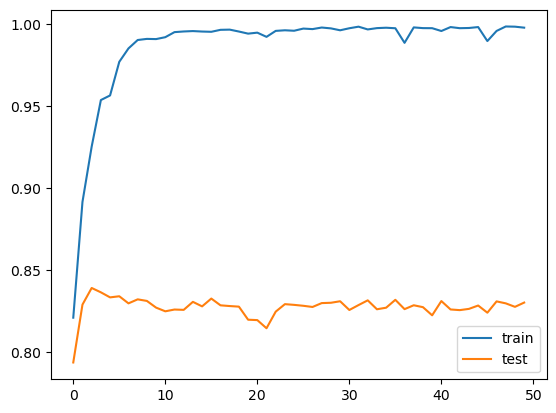

In [23]:
plot_acc(train_accuracies, test_accuracies)